<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [24]</a>'.</span>

In [1]:
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
import dask
import pandas as pd
import geopandas as gpd
import math
import numpy as np
import momepy
import matplotlib.pyplot as plt
import contextily as ctx
from math import ceil
from shapely.geometry import box
from tqdm import tqdm

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
# Parameters
local_crs = 4326
place = "Birmingham"
lat = 52.47790683186595
lng = -1.8999014571831943
country = "UK"
crs = 4326
radius = 20


In [4]:
streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)

buildings = gpd.read_parquet(f"../output/{place}/buildings_raw.pq").to_crs(local_crs)

study_area = gpd.read_parquet(f"../output/{place}/study_area.pq").to_crs(local_crs)

water = gpd.read_parquet(f"../output/{place}/water.pq").to_crs(local_crs)

rail = gpd.read_parquet(f"../output/{place}/rail_raw.pq").to_crs(local_crs).reset_index(drop=True)

/tmp/ipykernel_16379/371211060.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)


In [5]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='70GB')

client = Client(daskCluster)

client

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44157 instead
  warnings.warn(
2023-12-27 22:31:39,511 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:31:39,514 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:31:39,516 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:31:39,519 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:31:39,522 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 70GB due to system memory limit of 31.31 GiB
2023-12-27 22:31:39,525 - distributed.nanny.memory 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44157/status,
Dashboard: http://127.0.0.1:44157/status,Workers: 8
Total threads: 16,Total memory: 250.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41111,Workers: 8
Dashboard: http://127.0.0.1:44157/status,Total threads: 16
Started: Just now,Total memory: 250.47 GiB
Comm: tcp://127.0.0.1:41217,Total threads: 2
Dashboard: http://127.0.0.1:43605/status,Memory: 31.31 GiB
Nanny: tcp://127.0.0.1:46631,


In [6]:
streets[~streets['geometry'].is_valid]

,geometry


In [7]:
buildings[~buildings['geometry'].is_valid]

,geometry
21558,"POLYGON ((-2.16576 52.57635, -2.16576 52.57626..."
144804,"POLYGON ((-2.13104 52.58684, -2.13108 52.58695..."
173142,"POLYGON ((-2.16872 52.49606, -2.16859 52.49608..."
246327,"POLYGON ((-2.19130 52.57791, -2.19133 52.57783..."
16134,"POLYGON ((-1.64901 52.60353, -1.64982 52.60395..."
256551,"POLYGON ((-2.03846 52.61790, -2.03890 52.61791..."
324584,"POLYGON ((-1.82081 52.66952, -1.82068 52.66959..."
332386,"POLYGON ((-1.98223 52.57983, -1.98228 52.58006..."
410192,"POLYGON ((-1.89635 52.57940, -1.89638 52.57944..."
462725,"POLYGON ((-1.82479 52.56082, -1.82475 52.56081..."


In [8]:
water[~water['geometry'].is_valid]

,geometry


KeyboardInterrupt: 

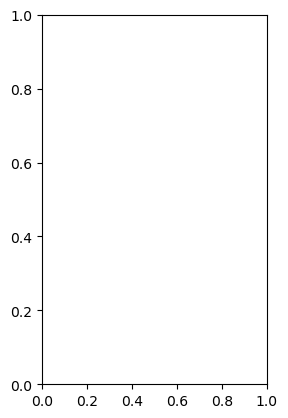

In [9]:
buildings.plot()

In [ ]:
# buildings = momepy.preprocess(buildings.reset_index(), size=40,
#                               compactness=0.2, islands=True)

In [ ]:
buildings

,geometry
0,"POLYGON ((-2.12263 52.61540, -2.12255 52.61540..."
1,"POLYGON ((-2.14199 52.60167, -2.14214 52.60166..."
3,"POLYGON ((-2.14186 52.50938, -2.14174 52.50940..."
5,"POLYGON ((-2.13426 52.60304, -2.13423 52.60306..."
7,"POLYGON ((-2.11305 52.63041, -2.11290 52.63043..."
...,...
428517,"POLYGON ((-2.08468 52.45566, -2.08454 52.45569..."
428519,"POLYGON ((-1.79802 52.45657, -1.79791 52.45661..."
428521,"POLYGON ((-2.02037 52.45209, -2.02033 52.45204..."
428522,"POLYGON ((-1.94666 52.31867, -1.94663 52.31862..."


In [ ]:
# Check for invalid geometries
invalid_geometries = buildings[~buildings.geometry.is_valid]

# If there are invalid geometries, attempt to fix them
if not invalid_geometries.empty:
    print(f"Found {len(invalid_geometries)} invalid geometries. Attempting to fix...")
    buildings.geometry = buildings.geometry.buffer(0)

    # Recheck for invalid geometries
    still_invalid = buildings[~buildings.geometry.is_valid]
    if still_invalid.empty:
        print("All invalid geometries fixed.")
    else:
        print(f"Could not fix {len(still_invalid)} geometries.")
else:
    print("No invalid geometries found.")

Found 14 invalid geometries. Attempting to fix...


All invalid geometries fixed.


In [ ]:
buildings['uID'] = momepy.unique_id(buildings)

In [ ]:
water_bodies_boundaries = []

# Explode the GeoDataFrame into a GeoSeries of polygons and multipolygons
gs = water.explode()

# Convert each polygon into a MultiLineString
mls = gs.geometry.boundary

# Convert the MultiLineString into a DataFrame
water_bodies = gpd.GeoDataFrame({'geometry': mls})

for water_body in water_bodies.geometry:
    # Create a LineString object from the coordinates
    water_bodies_boundaries.append(water_body)

# # Create a GeoDataFrame of the water area boundaries
water_bodies_boundaries = gpd.GeoDataFrame({'geometry': water_bodies_boundaries}).reset_index(drop=True)

/tmp/ipykernel_1355347/893087771.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gs = water.explode()


In [ ]:
enclosures = momepy.enclosures(streets, limit=study_area, additional_barriers=[water_bodies_boundaries, rail])

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/momepy/elements.py:1001: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = enclosures.sindex.query_bulk(


/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [ ]:
num_chunks = ceil(len(buildings) / 1400000)

In [ ]:
def split_bounds(bounds, num_chunks):
    minx, miny, maxx, maxy = bounds
    width = maxx - minx
    height = maxy - miny

    # Assuming a square grid for simplicity
    chunks_per_side = math.ceil(math.sqrt(num_chunks))
    chunk_width = width / chunks_per_side
    chunk_height = height / chunks_per_side

    chunks = []
    for i in range(chunks_per_side):
        for j in range(chunks_per_side):
            new_minx = minx + i * chunk_width
            new_miny = miny + j * chunk_height
            new_maxx = new_minx + chunk_width
            new_maxy = new_miny + chunk_height

            # Create a new bounding box (as a shapely box) for each chunk
            chunk_bounds = box(new_minx, new_miny, new_maxx, new_maxy)
            chunks.append(chunk_bounds)

    return gpd.GeoSeries(chunks)

# Example usage
chunks = split_bounds(enclosures.total_bounds, num_chunks)

In [ ]:
chunks = gpd.GeoDataFrame(geometry = chunks)
chunks["chunk_ID"] = range(len(chunks))
enclosures["centroid"] = enclosures.centroid
enclosures = enclosures.sjoin(chunks, how="left")
enclosures = enclosures[["geometry", "chunk_ID", "eID"]]

/tmp/ipykernel_1355347/865766905.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  enclosures["centroid"] = enclosures.centroid
/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [ ]:
chunks

,geometry,chunk_ID
0,"POLYGON ((-1.53191 52.25319, -1.53191 52.70582...",0


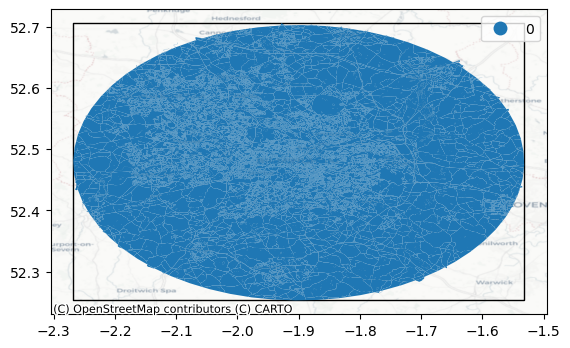

In [ ]:
# Plotting each chunk
fig, ax = plt.subplots()
chunks.plot(ax=ax, edgecolor='black', facecolor='none')
enclosures.plot(ax=ax, column='chunk_ID', categorical=True, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=buildings.crs)
plt.show()

In [ ]:
buildings = buildings[["geometry"]].sjoin(enclosures, how="left")

In [ ]:
buildings = buildings.dropna()[["geometry", "chunk_ID"]]
buildings["uID"] = range(len(buildings))
old_buildings = buildings
buildings = buildings.set_geometry('geometry')

In [ ]:
buildings = buildings.to_crs(local_crs)
enclosures = enclosures.to_crs(local_crs)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [ ]:
tessellation = gpd.GeoDataFrame()

for index, chunk in tqdm(chunks.iterrows(), total= chunks.shape[0]):
    chunk_tessellation = momepy.Tessellation(buildings[buildings["chunk_ID"]==index], unique_id='uID', enclosures=enclosures[enclosures["chunk_ID"] == index], use_dask = True).tessellation
    tessellation = pd.concat([tessellation, chunk_tessellation])
    
tessellation_old = tessellation


  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Geometry is in a geographic CRS. Use 'GeoDataFrame.to_crs()' to re-project geometries to a projected CRS before using Tessellation.

In [ ]:
# tessellation.plot()

In [ ]:
tessellation = tessellation_old

In [ ]:
tessellation.to_parquet(f"../output/{place}/tessellation_p1_raw.pq")

In [ ]:
# tessellation = gpd.read_parquet(f"../output/{place}/tessellation_p1_raw.pq")

In [ ]:
tessellation=tessellation.sort_values(by='uID').reset_index(drop=True).dropna(subset=['uID'])

In [ ]:
duplicate_gdf = tessellation[tessellation.duplicated('uID', keep=False)]

In [ ]:
@delayed
def find_valid_from_multiples(gdf, building):
    gdf = gdf[gdf.intersects(building)]
        
    if gdf.shape[0] > 1:
        smallest_area = gdf.geometry.area.idxmin()
        return gdf.loc[[smallest_area]]
    return gdf

# Using a list comprehension for conciseness and efficiency
results = dask.compute([
    find_valid_from_multiples(duplicate_gdf[duplicate_gdf['uID'] == uid].reset_index(), buildings[buildings["uID"] == uid].geometry.iloc[0])
    for uid in duplicate_gdf["uID"].unique()
])

# Concatenate the results into a single GeoDataFrame
a = gpd.GeoDataFrame(pd.concat(results[0], ignore_index=True))
tessellation = gpd.GeoDataFrame(pd.concat([tessellation, a], ignore_index=True))


In [ ]:
tessellation

In [ ]:
tessellation = tessellation.drop("eID", axis = 1)

In [ ]:
# Convert the 'uID' column of buildings to a set for efficient lookups
uIDs_buildings = set(buildings['uID'])

# Filter the tesellation GeoDataFrame to keep only rows with uID in buildings
tessellation = tessellation[tessellation['uID'].isin(uIDs_buildings)]


In [ ]:
# Convert the 'uID' column of buildings to a set for efficient lookups
uIDs_tessellation = set(tessellation['uID'])

# Filter the tesellation GeoDataFrame to keep only rows with uID in buildings
buildings = buildings[buildings['uID'].isin(uIDs_tessellation)]


In [ ]:
tessellation

In [ ]:
tessellation = tessellation[["uID", "geometry"]]
buildings = buildings[["uID", "geometry"]]

In [ ]:
tessellation[tessellation.duplicated('uID', keep=False)]

In [ ]:
combined = tessellation.merge(buildings, on='uID', how='inner').reset_index()
combined["uID"] = range(len(combined))
combined

In [ ]:
tessellation = gpd.GeoDataFrame(combined[["uID", "geometry_x"]], geometry='geometry_x')
tessellation = tessellation.rename(columns={'geometry_x': 'geometry'})

In [ ]:
tessellation = tessellation.set_geometry("geometry", crs=local_crs)

In [ ]:
buildings = gpd.GeoDataFrame(combined[["uID", "geometry_y"]], geometry='geometry_y')
buildings = buildings.rename(columns={'geometry_y': 'geometry'})

In [ ]:
buildings = buildings.set_geometry("geometry", crs=local_crs)

In [ ]:
tessellation.to_parquet(f"../output/{place}/tessellation_p2.pq")

In [ ]:
buildings.to_parquet(f"../output/{place}/buildings_p2.pq")

In [ ]:
streets.to_parquet(f"../output/{place}/streets_p2.pq")

In [ ]:
# # Create a figure and axis

# # Plot streets in blue on the same axis
# streets.plot(ax=ax, color='blue')

# # Plot buildings in red on the same axis
# buildings.plot(ax=ax, color='red')

# tessellation.plot(ax = ax, color = 'green')

# # Show the plot
# plt.show()